    0) 주가 변화를 바탕으로 다음 주가 변동 예측
        - 종목 : 현대 로템 > 방산 부문은 K계열 전차와 차륜형장갑차 양산사업, 창정비 사업
                 기간 : Sep 20, 2017 - Sep 20, 2022(5년) 
                 장소 : https://finance.yahoo.com/quote/064350.KS/history?p=064350.KS

    1) data 개요 : 1223행 6행으로 구성 
       - Close를 기준으로 분석 
    2) 결측치 처리와 정규분포 확인 
       - 결측치 없슴
       - log화 : 시시계열 data는 지수적으로 증가하는 경향이 있어 log하여 선형적으로 변환
    3) 시계열 안정성 분석 
    4) 학습, 테스트 데이터셋 생성
    5) 적정 ARIMA 모수 찾기 : (p:2 , q :0)
    6) ARIMA 모델 훈련과 테스트 : MAPE(11.93%)

In [2]:
#1) data 개요 : 시계열 데이터 준비
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# Time Series 생성
data_path = os.getenv('HOME')+'/aiffel/stock_prediction/data/064350.KS.csv' 
df = pd.read_csv(data_path, index_col='Date', parse_dates=True)
ts = df['Close']

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2017-09-20    17700.0
2017-09-21    17400.0
2017-09-25    16650.0
2017-09-26    16650.0
2017-09-27    17450.0
Name: Close, dtype: float64

    2) 결측치 처리와 정규분포 확인 
       2-1) 결측치 확인 : 없슴
       2-2) Close 시각화 및 log화 : 
           - 시계열(time series) 데이터를 차트
           - 평균과 편차 시각화 확인 : 평균과 편차 변동 없는 것으로 판단
       2-3) log화 : 시계열 data는 지수적으로 증가하는 경향이 있어 log하여 선형적으로 변환

In [3]:
#2-1): 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

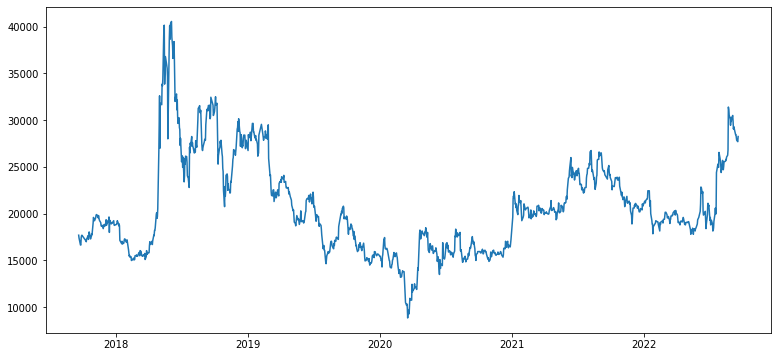

In [4]:
#2-2) Close 시각화 및 log화 : 시계열(time series) 데이터를 차트
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

plt.plot(ts)

In [5]:
#2-3) Close 시각화 및 log화 : log화 > 시계열 data는 지수적으로 증가하는 경향이 있어 log하여 선형적으로 변환
ts_log = np.log(ts)

    3) 시계열 안정성 분석
        3-1) 함수 loding : plot_rolling_statistics, Augmented Dicky-Fuller Test
        3-2) 시각화 및 그래프 분석 : p-value = 0.126339 
      

In [6]:
# 3) 시계열 안정성 분석 : 함수 loding
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

In [7]:
# 3) 시계열 안정성 분석 : 함수 loding
#augmented_dickey_fuller_test 정보확인
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


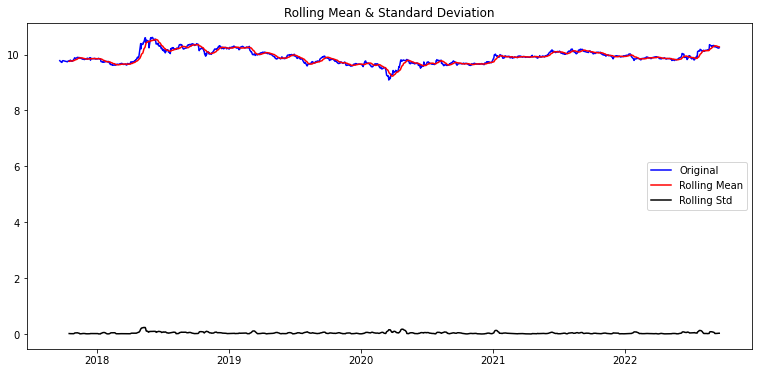

Results of Dickey-Fuller Test:
Test Statistic                   -2.456813
p-value                           0.126339
#Lags Used                        0.000000
Number of Observations Used    1222.000000
Critical Value (1%)              -3.435713
Critical Value (5%)              -2.863908
Critical Value (10%)             -2.568031
dtype: float64


In [8]:
#  3) 시계열 안정성 분석 
#정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 



In [ ]:
    4) 학습, 테스트 데이터셋 생성
        -train data : 90%, test data : 10%

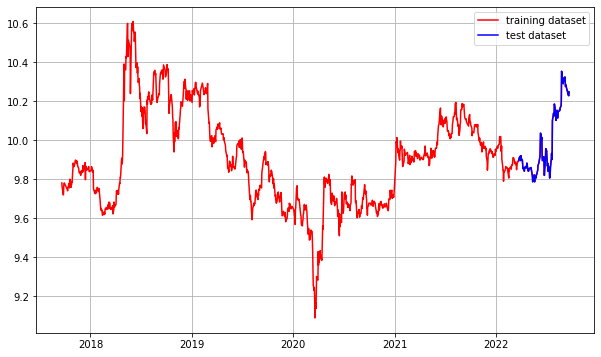

In [13]:
#4) 학습, 테스트 데이터셋 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

    5) 적정 ARIMA 모수 찾기 
        1) ACF, PCAF 그리기 .. p = 2, q = 0
        2) d차분 : 안정화

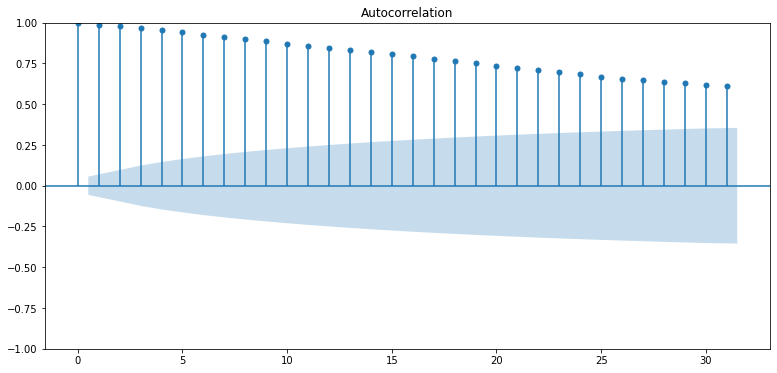

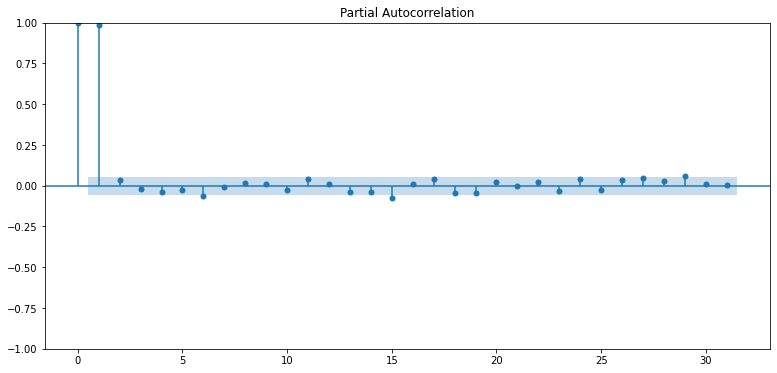

In [14]:
#5)적정 ARIMA 모수 찾기  :ACF, PACF 그려보기 -> p:2 , q :0
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                  -36.312695
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1221.000000
Critical Value (1%)              -3.435717
Critical Value (5%)              -2.863910
Critical Value (10%)             -2.568032
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.306486e+01
p-value                        2.012145e-24
#Lags Used                     2.000000e+01
Number of Observations Used    1.200000e+03
Critical Value (1%)           -3.435811e+00
Critical Value (5%)           -2.863952e+00
Critical Value (10%)          -2.568054e+00
dtype: float64


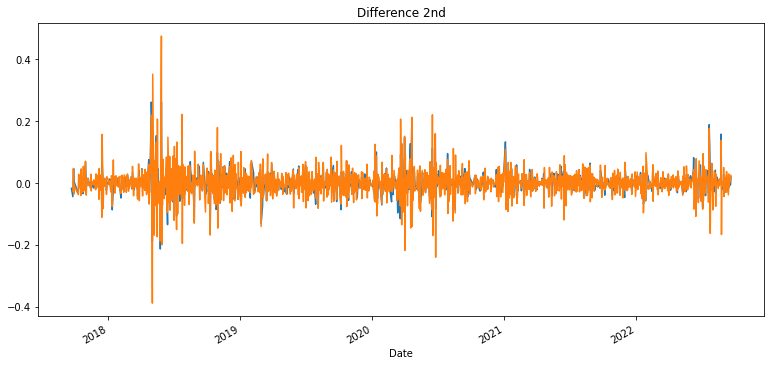

In [15]:
#5 )적정 ARIMA 모수 찾기 # 차분 안정성 확인 -> d 구하기 # 1차 차#STEP 5 : 적정 ARIMA 모수 찾기

diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


In [45]:
#6): ARIMA 모델 훈련과 테스트
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1100
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2110.795
Date:                Tue, 20 Sep 2022   AIC                          -4211.589
Time:                        09:22:57   BIC                          -4186.574
Sample:                             0   HQIC                         -4202.126
                               - 1100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8794      0.102     96.625      0.000       9.679      10.080
ar.L1          0.5858      0.361      1.623      0.105      -0.121       1.293
ar.L2          0.3989      0.356      1.119      0.2

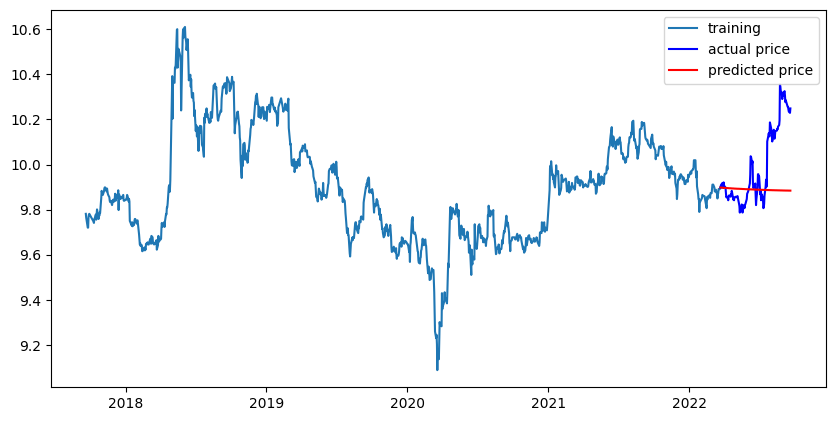

In [46]:
#6): ARIMA 모델 훈련과 테스트
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [47]:
##6) : ARIMA 모델 훈련과 테스트
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  21161709.973671976
MAE:  3056.2427437672213
RMSE:  4600.1858629485805
MAPE: 11.93%


    0) 주가 변화를 바탕으로 다음 주가 변동 예측
        - 종목 :  현대차 : 자동차 및 자동차부품을 제조 및 판매하는 완성차 제조업체
             기간 : Sep 20, 2017 - Sep 20, 2022(5년) 

    1) data 개요 : 1223행 6열으로 구성 
       - Close를 기준으로 분석 
    2) 결측치 처리와 정규분포 확인 
       - 결측치 없슴
       - log화 : 시시계열 data는 지수적으로 증가하는 경향이 있어 log하여 선형적으로 변환
    3) 시계열 안정성 분석 
    4) 학습, 테스트 데이터셋 생성
    5) 적정 ARIMA 모수 찾기 : (p:2 , q :0)
    6) ARIMA 모델 훈련과 테스트 : MAPE(8.84%)

In [110]:
#1) data 개요 : 시계열 데이터 준비
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# Time Series 생성
data_path = os.getenv('HOME')+'/aiffel/stock_prediction/data/005380.KS.csv' 
df1 = pd.read_csv(data_path, index_col='Date', parse_dates=True)
ts1 = df1['Close']

print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
2017-09-20    142000.0
2017-09-21    141500.0
2017-09-25    141000.0
2017-09-26    141000.0
2017-09-27    147500.0
Name: Close, dtype: float64

    2) 결측치 처리와 정규분포 확인 
       2-1) 결측치 확인 : 없슴
       2-2) Close 시각화 및 log화 : 
           - 시계열(time series) 데이터를 차트
           - 평균과 편차 시각화 확인 : 평균과 편차 변동 없는 것으로 판단
       2-3) log화 : 시계열 data는 지수적으로 증가하는 경향이 있어 log하여 선형적으로 변환

In [111]:
#2-1): 결측치 처리
ts1 = ts1.interpolate(method='time')
ts1[ts1.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

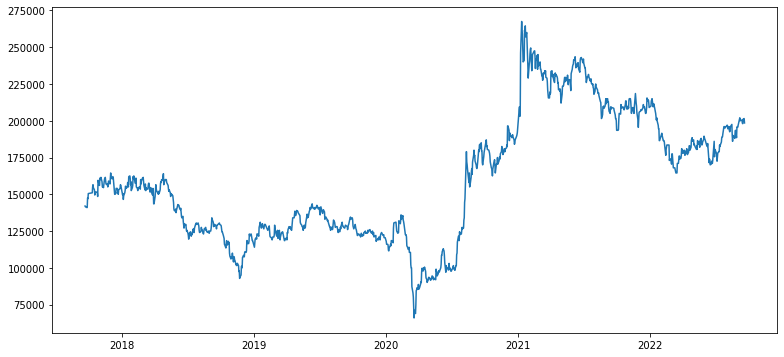

In [112]:
#2-2) Close 시각화 및 log화 : 시계열(time series) 데이터를 차트
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

plt.plot(ts1)

In [113]:
#2-3) Close 시각화 및 log화 : log화 > 시계열 data는 지수적으로 증가하는 경향이 있어 log하여 선형적으로 변환
ts1_log = np.log(ts1)

    3) 시계열 안정성 분석
        3-1) 함수 loding : plot_rolling_statistics, Augmented Dicky-Fuller Test
        3-2) 시각화 및 그래프 분석 : p-value = 0.583066

In [114]:
# 3) 시계열 안정성 분석 : 함수 loding
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

In [115]:
# 3) 시계열 안정성 분석 : 함수 loding
#augmented_dickey_fuller_test 정보확인
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

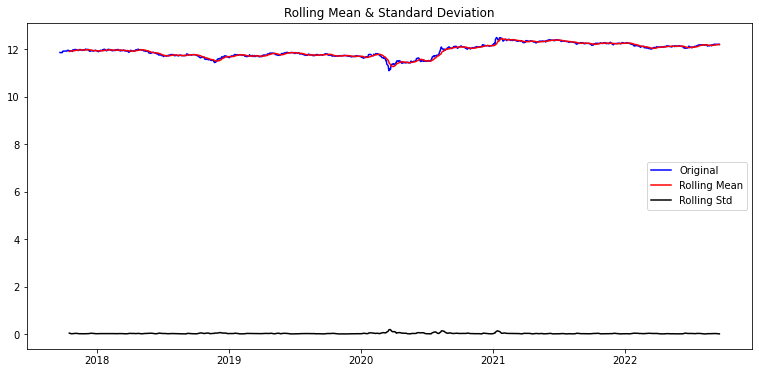

Results of Dickey-Fuller Test:
Test Statistic                   -1.398352
p-value                           0.583066
#Lags Used                        1.000000
Number of Observations Used    1221.000000
Critical Value (1%)              -3.435717
Critical Value (5%)              -2.863910
Critical Value (10%)             -2.568032
dtype: float64


In [116]:
#  3) 시계열 안정성 분석 
#정성적 그래프 분석
plot_rolling_statistics(ts1_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts1_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', period = 30) 

    4) 학습, 테스트 데이터셋 생성
        -train data : 90%, test data : 10%

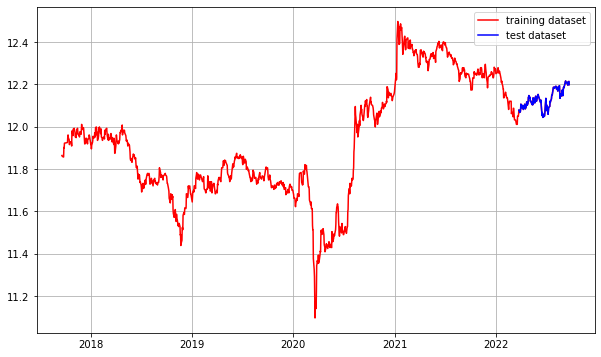

In [117]:
#4) 학습, 테스트 데이터셋 생성
train_data, test_data = ts1_log[:int(len(ts1_log)*0.9)], ts1_log[int(len(ts1_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts1_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts1_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

    5) 적정 ARIMA 모수 찾기 
        1) ACF, PCAF 그리기 .. p = 2, q = 0
        2) d차분 : 안정화

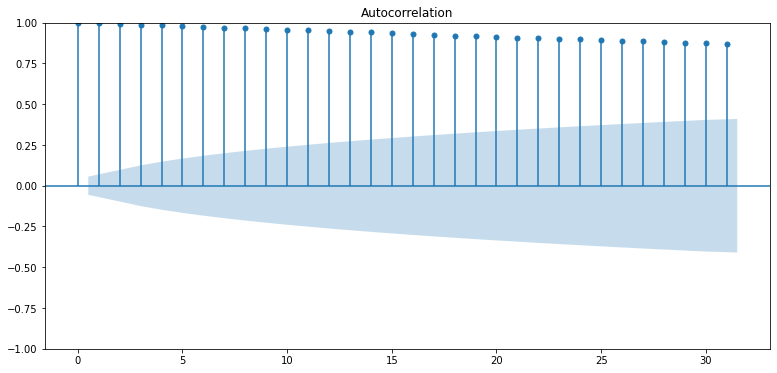

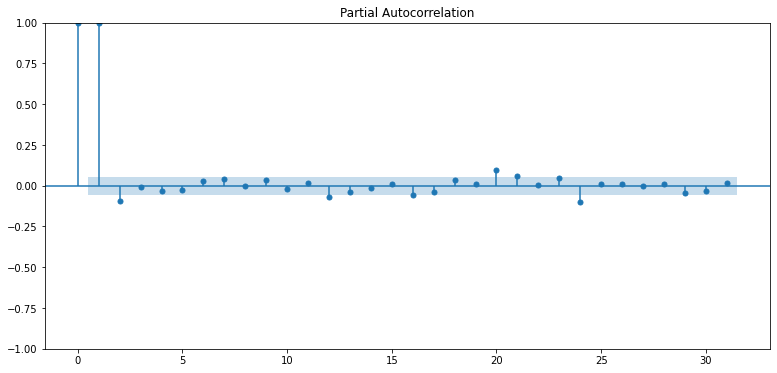

In [91]:
#5)적정 ARIMA 모수 찾기  :ACF, PACF 그려보기 -> p:2 , q :0
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -32.444138
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1221.000000
Critical Value (1%)              -3.435717
Critical Value (5%)              -2.863910
Critical Value (10%)             -2.568032
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.182291e+01
p-value                        8.332585e-22
#Lags Used                     2.200000e+01
Number of Observations Used    1.198000e+03
Critical Value (1%)           -3.435820e+00
Critical Value (5%)           -2.863956e+00
Critical Value (10%)          -2.568056e+00
dtype: float64


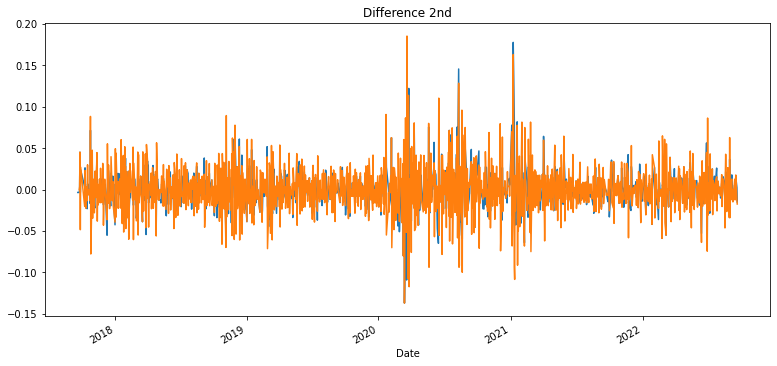

In [92]:
#5 )적정 ARIMA 모수 찾기 # 차분 안정성 확인 -> d 구하기 # 1차 차#STEP 5 : 적정 ARIMA 모수 찾기

diff_1 = ts1_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


In [93]:
#6): ARIMA 모델 훈련과 테스트
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1100
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2622.929
Date:                Tue, 20 Sep 2022   AIC                          -5235.859
Time:                        13:00:28   BIC                          -5210.844
Sample:                             0   HQIC                         -5226.395
                               - 1100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9240      0.198     60.374      0.000      11.537      12.311
ar.L1          1.3311      0.223      5.977      0.000       0.895       1.768
ar.L2         -0.3337      0.222     -1.502      0.1

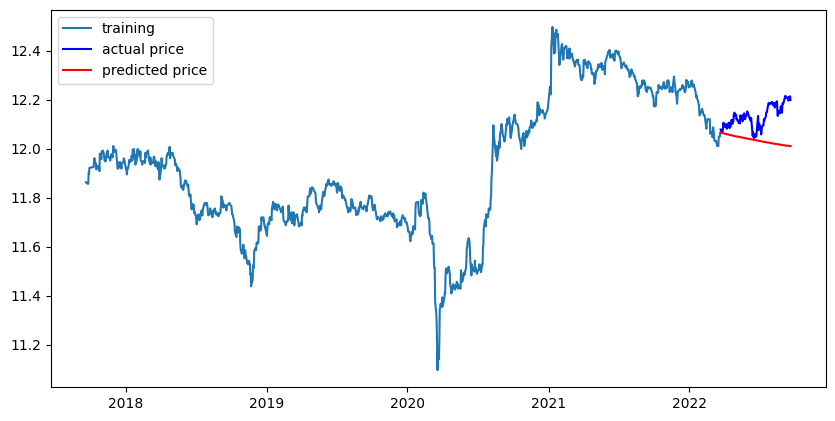

In [94]:
#6): ARIMA 모델 훈련과 테스트
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [95]:
##6) : ARIMA 모델 훈련과 테스트
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  388559066.34766436
MAE:  16817.719882838446
RMSE:  19711.901642095934
MAPE: 8.84%


    0) 주가 변화를 바탕으로 다음 주가 변동 예측
        - 종목 :  Roblox : 메타버스
             기간 : Sep 20, 2017 - Sep 20, 2022(5년) 

    1) data 개요 : 386행 6열으로 구성 
       - Close를 기준으로 분석 
    2) 결측치 처리와 정규분포 확인 
       - 결측치 없슴
       - log화 : 시시계열 data는 지수적으로 증가하는 경향이 있어 log하여 선형적으로 변환
    3) 시계열 안정성 분석 
    4) 학습, 테스트 데이터셋 생성
    5) 적정 ARIMA 모수 찾기 : (p:2 , q :0)
    6) ARIMA 모델 훈련과 테스트 : MAPE(8.85%)

In [96]:
#1) data 개요 : 시계열 데이터 준비
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# Time Series 생성
data_path = os.getenv('HOME')+'/aiffel/stock_prediction/data/RBLX.csv' 
df2 = pd.read_csv(data_path, index_col='Date', parse_dates=True)
ts2 = df2['Close']

print(type(ts2))
ts2.head()

<class 'pandas.core.series.Series'>


Date
2021-03-10    69.500000
2021-03-11    73.900002
2021-03-12    69.699997
2021-03-15    72.150002
2021-03-16    77.000000
Name: Close, dtype: float64

    2) 결측치 처리와 정규분포 확인 
       2-1) 결측치 확인 : 없슴
       2-2) Close 시각화 및 log화 : 
           - 시계열(time series) 데이터를 차트
           - 평균과 편차 시각화 확인 : 평균과 편차 변동 없는 것으로 판단
       2-3) log화 : 시계열 data는 지수적으로 증가하는 경향이 있어 log하여 선형적으로 변환

In [98]:
#2-1): 결측치 처리
ts2 = ts2.interpolate(method='time')
ts2[ts2.isna()]   # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

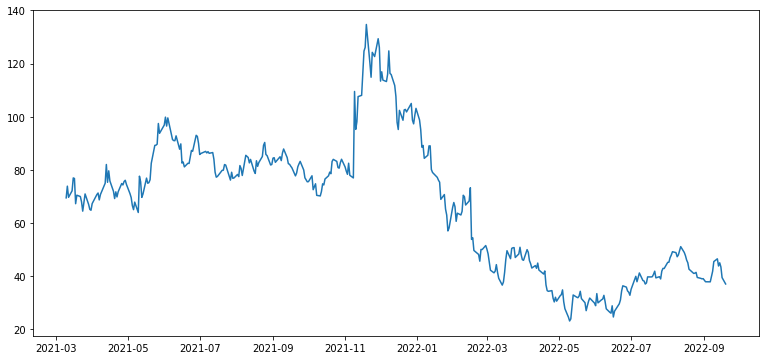

In [99]:
#2-2) Close 시각화 및 log화 : 시계열(time series) 데이터를 차트
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

plt.plot(ts2)

In [100]:
#2-3) Close 시각화 및 log화 : log화 > 시계열 data는 지수적으로 증가하는 경향이 있어 log하여 선형적으로 변환
ts2_log = np.log(ts2)

    3) 시계열 안정성 분석
        3-1) 함수 loding : plot_rolling_statistics, Augmented Dicky-Fuller Test
        3-2) 시각화 및 그래프 분석 : p-value = 0.719673

In [102]:
# 3) 시계열 안정성 분석 : 함수 loding
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [ ]:
# 3) 시계열 안정성 분석 : 함수 loding
#augmented_dickey_fuller_test 정보확인
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

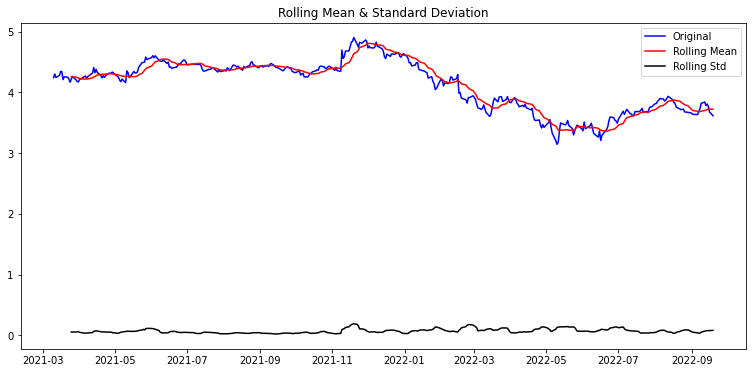

Results of Dickey-Fuller Test:
Test Statistic                  -1.088407
p-value                          0.719673
#Lags Used                       0.000000
Number of Observations Used    385.000000
Critical Value (1%)             -3.447450
Critical Value (5%)             -2.869077
Critical Value (10%)            -2.570785
dtype: float64


In [103]:
#  3) 시계열 안정성 분석 
#정성적 그래프 분석
plot_rolling_statistics(ts2_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts2_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 30) 

    4) 학습, 테스트 데이터셋 생성
        -train data : 90%, test data : 10%

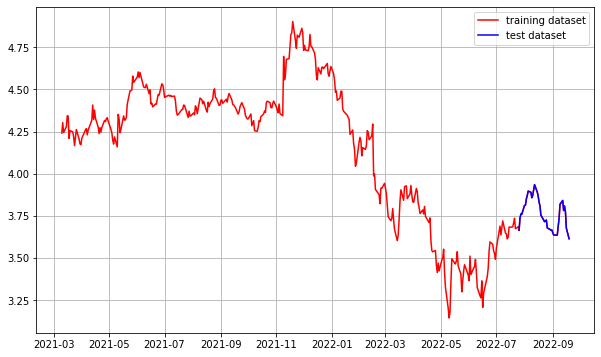

In [104]:
#4) 학습, 테스트 데이터셋 생성
train_data, test_data = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

    5) 적정 ARIMA 모수 찾기 
        1) ACF, PCAF 그리기 .. p = 2, q = 0
        2) d차분 : 안정화

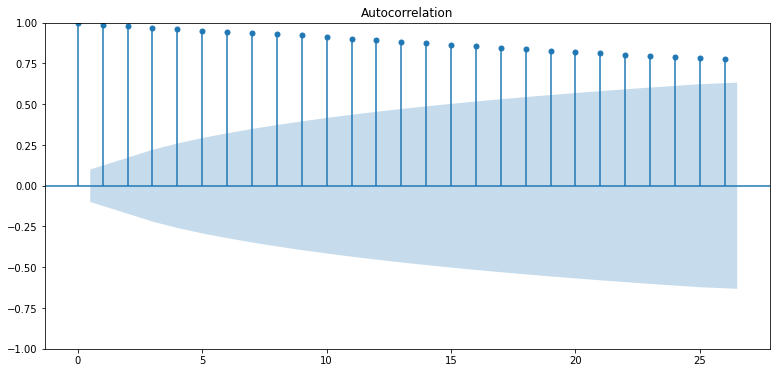

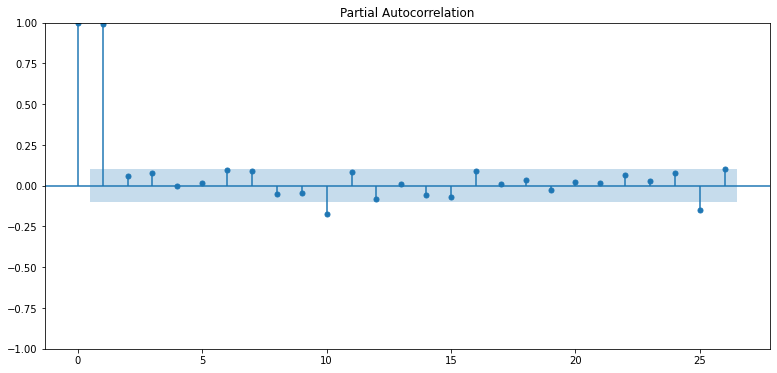

In [105]:
#5)적정 ARIMA 모수 찾기  :ACF, PACF 그려보기 -> p:2 , q :0
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -20.372283
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    384.000000
Critical Value (1%)             -3.447495
Critical Value (5%)             -2.869096
Critical Value (10%)            -2.570795
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.777763e+00
p-value                        6.861827e-17
#Lags Used                     1.200000e+01
Number of Observations Used    3.710000e+02
Critical Value (1%)           -3.448100e+00
Critical Value (5%)           -2.869362e+00
Critical Value (10%)          -2.570937e+00
dtype: float64


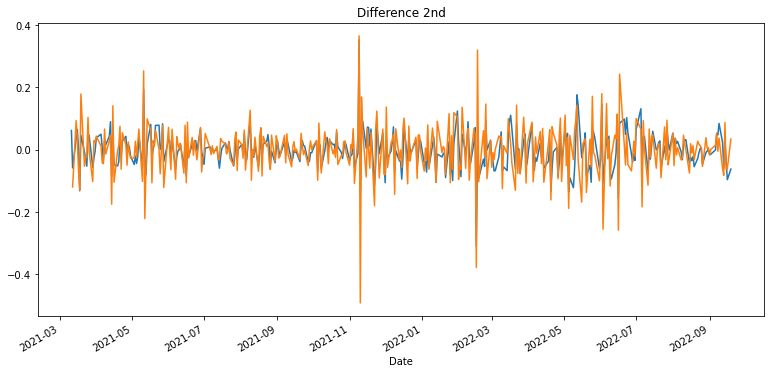

In [106]:
#5 )적정 ARIMA 모수 찾기 # 차분 안정성 확인 -> d 구하기 # 1차 차#STEP 5 : 적정 ARIMA 모수 찾기

diff_1 = ts2_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [107]:
#6): ARIMA 모델 훈련과 테스트
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  347
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 493.571
Date:                Tue, 20 Sep 2022   AIC                           -977.142
Time:                        13:18:33   BIC                           -957.896
Sample:                             0   HQIC                          -969.479
                                - 347                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0715      0.389     10.459      0.000       3.309       4.834
ar.L1          1.6742      0.345      4.854      0.000       0.998       2.350
ar.L2         -0.6762      0.342     -1.978      0.0

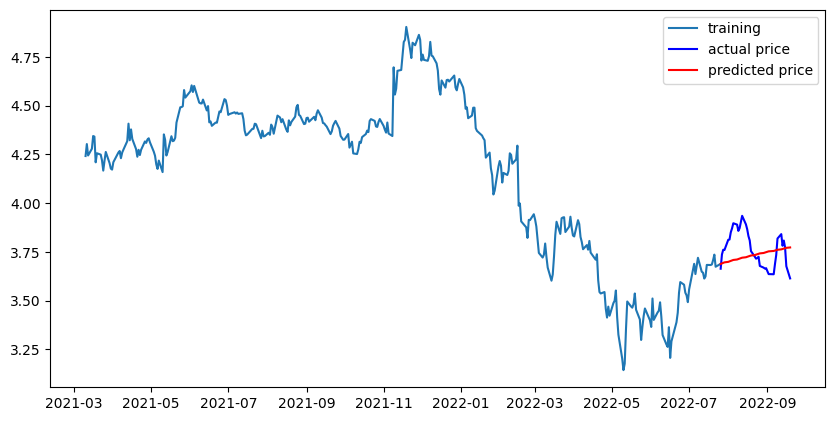

In [108]:
#6): ARIMA 모델 훈련과 테스트
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [109]:
##6) : ARIMA 모델 훈련과 테스트
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22.36625291115938
MAE:  3.9470706873787047
RMSE:  4.729297295704657
MAPE: 8.85%
